# Gradiente Descendente Paralelo 
#### Estudo de Abordagens de Implementação
---
**Créditos:**
 Adaptação do código original desenvolvido por [Angad Gill](https://github.com/angadgill) e [Sharath Rao](https://github.com/sharathrao13) com base no paper de Zinkevich, M., Weimer, M., Li, L., & Smola, A. (2010). [Parallelized stochastic gradient descent](http://papers.nips.cc/paper/4006-parallelized-stochastic-gradient-descent). 

## Dataset

Dataset Diamonds, blablablab
~52000 observações com 8 características e preços correspondentes de diamantes, para regressão linear.

In [1]:
%matplotlib inline
from sklearn.datasets import make_regression
from sklearn.model_selection import ShuffleSplit
import numpy as np
from matplotlib import pyplot as plt

In [2]:
n_samples = 1000
n_features = 100
seed = 1
effective_rank = 100

In [3]:
n_samples = 1000
n_features = 100
seed = 1
effective_rank = 100

In [4]:
X, y = make_regression(n_samples=n_samples, n_features=n_features, 
                       random_state=seed, noise=0.0, effective_rank=effective_rank)

Preparação dos conjuntos para treinamento e testes:

In [5]:
rs = ShuffleSplit(n_splits=5, test_size=.2, random_state=0)

In [6]:
for train_index, test_index in rs.split(X):
    pass

In [7]:
X_train = X[train_index]
X_test = X[test_index]
y_train = y[train_index]
y_test = y[test_index]

## 
## SGD "Normal" (baseline)

Treinameno do modelo com coleta da taxa de acurácia a cada iteração:

In [8]:
from sklearn.linear_model import SGDRegressor

In [9]:
# Número máximo de iterações:
n_iter = 5000

In [10]:
# Modelo dde regressão do SciKit-Learn
sgd = SGDRegressor(max_iter = n_iter, tol = 0.001)

In [11]:
# Treinamento do modelo e estatísticas
%time sgd.fit(X_train, y_train)

CPU times: user 651 ms, sys: 8.05 ms, total: 659 ms
Wall time: 548 ms


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=5000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [12]:
# Acurácia 
sgd.score(X_test, y_test)

0.5487972399528447

In [13]:
# Availiação
scores_base = []
sgd = SGDRegressor(max_iter=1, tol=0.001, warm_start=True)
for i in range(n_iter):
    sgd.partial_fit(X_train, y_train)
    scores_base += [sgd.score(X_test, y_test)]

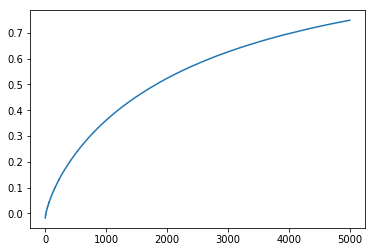

In [14]:
plt.plot(range(len(scores_base)), scores_base)

In [15]:
# acurácia final, obtida sobre o conjunto de testes:
scores_base[-1]

0.7492325864558325


# SGD Paralelo
Comparação de diferentes abordagens de paralelização

In [16]:
from joblib import Parallel, delayed
import utils
import importlib
importlib.reload(utils)

<module 'utils' from '/home/jeff/github/gdp/utils.py'>

### Cenário 1:
Neste cenário o dataset é dividido em partes iguais e cada uma é atribuída a um worker. Os pesos (parâmetros) finais são calculados uma única vez quando todos terminam o processamento.

In [17]:
# Quantidade de workers
n_jobs = 4

# Treinamento
%time scores = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1/n_jobs, overlap=False)

CPU times: user 18.6 s, sys: 180 ms, total: 18.8 s
Wall time: 9.43 s


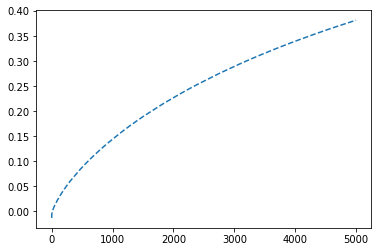

In [18]:
utils.plot_scores(scores)

### Cenário 2:
Neste cenário, todos os workers tem acesso a todo o conjunto de dados. Os pesos são finais são calculados uma única vez quando todos terminam o processamento.

4 workers:

In [19]:
n_jobs = 4
%time scores_4 = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True, verbose=True)

CPU times: user 32.9 s, sys: 664 ms, total: 33.6 s
Wall time: 16.4 s


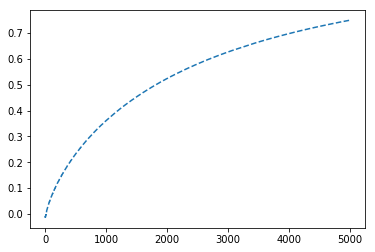

In [20]:
utils.plot_scores(scores_4)

20 workers:

In [21]:
n_jobs = 20
%time scores_20 = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True, verbose=True)

CPU times: user 2min 35s, sys: 2.01 s, total: 2min 37s
Wall time: 1min 18s


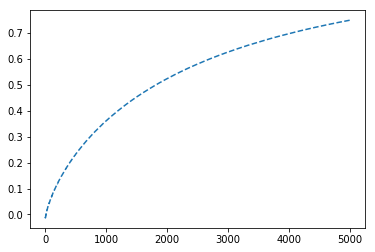

In [22]:
utils.plot_scores(scores_20)

50 workers:

In [23]:
n_jobs = 50
%time scores_50 = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True, verbose=True)

CPU times: user 6min 19s, sys: 4.1 s, total: 6min 23s
Wall time: 3min 11s


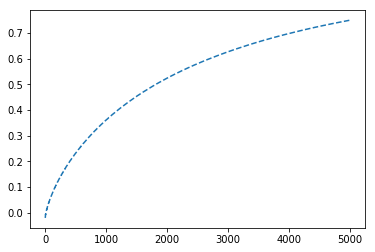

In [24]:
utils.plot_scores(scores_50)

100 workers:

In [25]:
n_jobs = 100
%time scores_100 = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True, verbose=True)

CPU times: user 12min 21s, sys: 7.9 s, total: 12min 29s
Wall time: 6min 14s


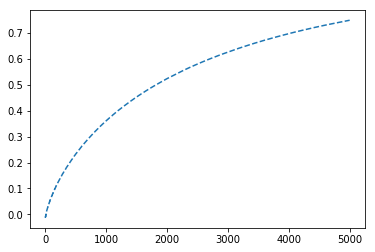

In [26]:
utils.plot_scores(scores_100)

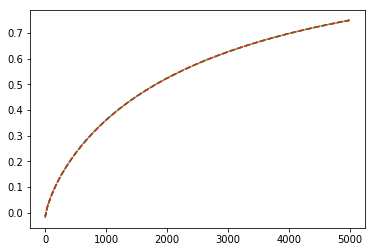

In [27]:
plt.figure(1)
for s in [scores_4, scores_20, scores_50, scores_100]:
    s = np.array(s).T
    plt.plot(range(len(s[-1])), s[-1], '--')

### Cenário 3:
Neste cenário uma porcentagem dos dados é distribuída a cada worker. O mesmo exemplo pode ser acessado por mais de um deles (overlap). A sincronização é feita apenas ao final.

50% dos dados para cada worker:

In [28]:
n_jobs = 4
%time scores = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=0.5, overlap=True)

CPU times: user 20.9 s, sys: 224 ms, total: 21.1 s
Wall time: 10.6 s


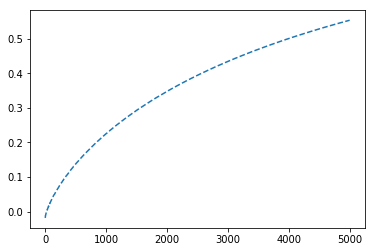

In [29]:
utils.plot_scores(scores)

25% dos dados para cada worker:

In [30]:
n_jobs = 4
%time scores = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=0.25, overlap=True)

CPU times: user 20.3 s, sys: 208 ms, total: 20.5 s
Wall time: 10.3 s


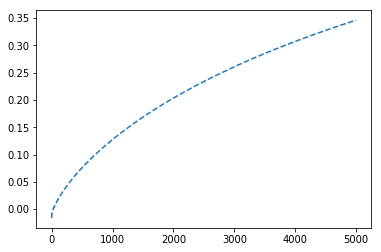

In [31]:
utils.plot_scores(scores)

### Cenário 4:
No cenário 4, todos os workers processam todo o conjunto de dados, mas a sincronização dos resultados é feita não apenas ao final, mas também durante o processamento.

Com 2 sincronizações:

In [32]:
importlib.reload(utils)

<module 'utils' from '/home/jeff/github/gdp/utils.py'>

In [33]:
n_jobs = 4
n_sync = 2
%time scores_2_sync = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)

Synced at iteration: 2500
CPU times: user 34.3 s, sys: 649 ms, total: 35 s
Wall time: 17.1 s


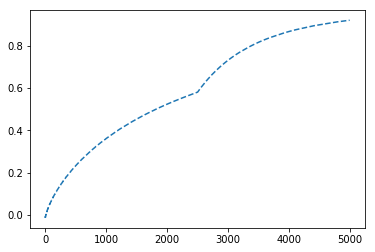

In [34]:
utils.plot_scores(scores_2_sync)

Com 5 sicncronizações:

In [35]:
n_jobs = 4
n_sync = 5
%time scores_5_sync = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)

Synced at iteration: 1000
Synced at iteration: 2000
Synced at iteration: 3000
Synced at iteration: 4000
CPU times: user 32.2 s, sys: 701 ms, total: 32.9 s
Wall time: 16.1 s


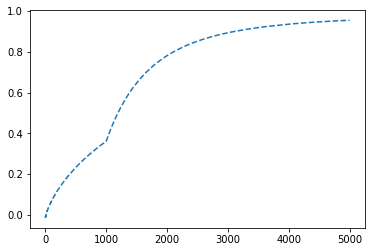

In [36]:
utils.plot_scores(scores_5_sync)

In [37]:
importlib.reload(utils)

<module 'utils' from '/home/jeff/github/gdp/utils.py'>

Com 10 sincronizações:

In [38]:
n_jobs = 4
n_sync = 10
%time scores_10_sync = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)

Synced at iteration: 500
Synced at iteration: 1000
Synced at iteration: 1500
Synced at iteration: 2000
Synced at iteration: 2500
Synced at iteration: 3000
Synced at iteration: 3500
Synced at iteration: 4000
Synced at iteration: 4500
CPU times: user 32.2 s, sys: 628 ms, total: 32.8 s
Wall time: 16 s


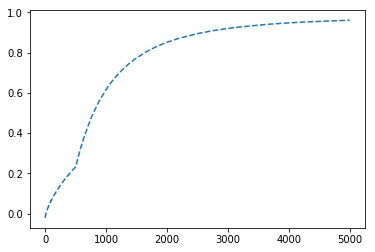

In [39]:
utils.plot_scores(scores_10_sync)

Comparativo dos testes:

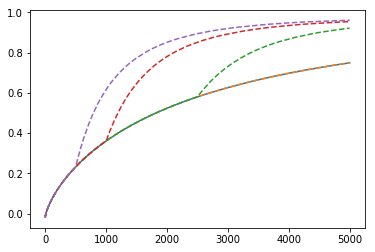

In [40]:
plt.figure(1)
plt.plot(range(len(scores_base)), scores_base)
for s in [scores_4, scores_2_sync, scores_5_sync, scores_10_sync]:
    s = np.array(s).T
    plt.plot(range(len(s[-1])), s[-1], '--')

In [41]:
importlib.reload(utils)

<module 'utils' from '/home/jeff/github/gdp/utils.py'>

Com 4 sincronizações:

In [42]:
n_jobs = 4
n_sync = 4
%time scores_try = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter/n_jobs, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)

TypeError: 'float' object cannot be interpreted as an integer

NameError: name 'scores_try' is not defined

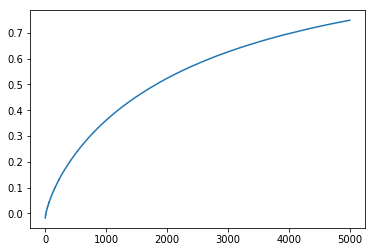

In [43]:
plt.figure(1)
plt.plot(range(len(scores_base)), scores_base)
for s in [scores_try]:
    s = np.array(s).T
    plt.plot(range(len(s[-1])), s[-1], '--')